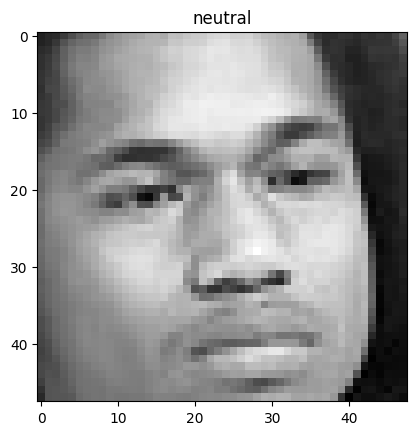

In [45]:
import torch                          # Le cœur de PyTorch : tensors, calculs, GPU
import torch.nn as nn                 # Contient toutes les couches du réseau (Conv2D, Linear, etc.)
import torch.optim as optim           # Optimiseurs pour entraîner le modèle (Adam, SGD, etc.)
from torch.utils.data import DataLoader  # Pour gérer le batching et le shuffle des datasets
from torchvision import datasets, transforms, models  # Outils pour datasets, transformations et modèles pré-entraînés


import numpy as np                    # Manipulation de tableaux, conversion images → tensors
import pandas as pd                   # Pour lire et écrire le fichier test_template.csv
import os                             # Gestion des fichiers et dossiers

# -----------------------------
# Librairies pour la visualisation
# -----------------------------
import matplotlib.pyplot as plt       # Visualiser les images et tracer des courbes

# -----------------------------
# Librairies pour la vision par ordinateur
# -----------------------------
import cv2                            # Capturer la webcam et détecter les visages
from PIL import Image 
from skimage import io
import matplotlib.pyplot as plt
import os, random

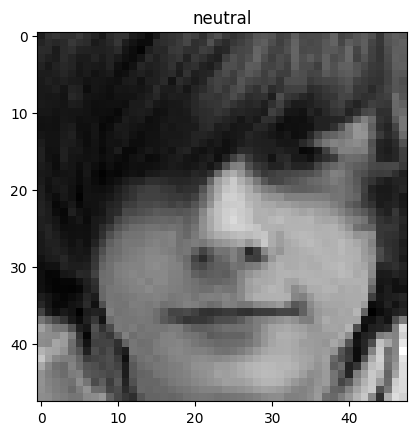

In [53]:

emotion = 'neutral'
path = f'data/dataTrain/train/{emotion}/'
img = io.imread(os.path.join(path, random.choice(os.listdir(path))))
plt.imshow(img, cmap='gray')
plt.title(emotion)
plt.show()

In [50]:
import os

for emotion in os.listdir('data/dataTrain/train'):
    print(emotion, ":", len(os.listdir(os.path.join('data/dataTrain/train', emotion))))


happy : 7215
sad : 4830
fear : 4097
surprise : 3171
neutral : 4965
angry : 3995
disgust : 436


In [67]:
transform = transforms.Compose([
    transforms.Grayscale(),            # images en niveaux de gris
    transforms.Resize((48, 48)),       # redimensionne à 48x48
    transforms.ToTensor(),             # convertit en tenseur [0,1]
    transforms.Normalize((0.5,), (0.5,)) # normalise entre -1 et 1
])

train_data = datasets.ImageFolder("data/dataTrain/train", transform=transform)
test_data  = datasets.ImageFolder("data/dataTest",  transform=transform)


In [68]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_data, batch_size=64, shuffle=False)

images, labels = next(iter(train_loader))
print(images.shape)
print(labels.shape)
print(labels[:10])




torch.Size([64, 1, 48, 48])
torch.Size([64])
tensor([5, 4, 4, 3, 5, 3, 3, 3, 0, 3])
